# Crater Detection CNN Pipeline Pt 2 and Pt 3. Model Training and Prediction

## Model Architecture: DeepLabV3+

Author: cssprad1 and jordancaraballo

Version: 0.2.0


This notebook is used as the primary view for to create and train a CNN to produce crater maps on Enceladus. 

In [1]:
import os
import sys
import time
import datetime
import atexit
import logging
from pathlib import Path

from itertools import chain

import numpy as np
import cupy as cp
import pandas as pd
import xarray as xr
import rioxarray as rxr
import tensorflow as tf

sys.path.append('/insert_path/here')

from gc import callbacks
from tensorflow_caney.utils.losses import get_loss
from tensorflow_caney.utils.metrics import get_metrics
from tensorflow_caney.utils.callbacks import get_callbacks
from tensorflow_caney.utils.model import get_model
from tensorflow_caney.utils.optimizers import get_optimizer
from tensorflow_caney.networks.deeplabv3_plus import deeplab_v3_plus
from tensorflow_caney.networks.unet import unet_batchnorm as unet
from tensorflow_caney.utils.segmentation_tools import SegmentationDataLoader
from tensorflow_caney.utils.data import get_dataset_filenames
from tensorflow_caney.utils.system import set_mixed_precision, set_xla
from tensorflow_caney.utils.system import seed_everything, set_gpu_strategy
from tensorflow_caney.config.cnn_config import Config
from tensorflow_caney.utils import indices

try:
    import omegaconf
except ModuleNotFoundError:
    !pip install omegaconf
    import omegaconf

2022-08-12 10:04:46.565423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `tf.keras` framework.


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.INFO)
formatter = logging.Formatter(
    "%(asctime)s; %(levelname)s; %(message)s", "%Y-%m-%d %H:%M:%S"
)
ch.setFormatter(formatter)
logger.addHandler(ch)

## Constants

Data paths and output paths to be used later.

In [3]:
# CSV that lists scenes to use as base for training and validation data.
DATA_CSV = '/insert_path/here'

# Directory that has training and testing data. Will use as parent dir for output and model saving.
DATA_DIR = '/insert_path/here'

# File to predict with. Either use regex (*, etc) for multiple files or declare specifically.
INFERENCE_REGEX = '/insert_path/here'

GPU_DEVICES = os.environ.get('CUDA_VISIBLE_DEVICES')

## Define config string

In [4]:
omega_conf_string = \
"""
experiment_name: enceladus-crater-detection
experiment_type: crater-mask-1.9.2-dlv3

data_dir:  'placeholder'
model_dir: '${data_dir}/placeholder'

seed: 42
mixed_precision: True
xla: False

input_bands:
  - 1

output_bands:
  - 1

substract_labels: False
normalize: 1

expand_dims: True
tile_size: 256
include_classes: True
augment: True

# standardization functions: local, global, mixed
# global standardization
# mixed standardization
# standardization: 'local'

batch_size: 64
n_classes: 3
test_size: 0.20
learning_rate: 3e-4
max_epochs: 1000
patience: 10
no_data: 0
nodata_fractional: True
nodata_fractional_tolerance: 0.75

model: "tfc.networks.deeplabv3_plus.deeplab_v3_plus(nclass=3, input_size=(256, 256, 1))"
# model: "tfc.networks.unet.unet_batchnorm(nclass=3, input_size=(128, 128, 1),maps=[64, 128, 256, 512, 1024])"
# model: "sm.Unet('resnet34', input_shape=(128, 128, 3), encoder_weights=None, classes=1, activation='sigmoid')"

loss: 'tf.keras.losses.CategoricalCrossentropy()'
# loss: 'tf.keras.losses.BinaryCrossentropy()'
# loss: sm.losses.CategoricalFocalLoss
# loss: sm.losses.categorical_focal_dice_loss
# loss: sm.losses.categorical_focal_jaccard_loss
# loss: 'sm.losses.BinaryCELoss()'
# loss: 'sm.losses.DiceLoss(smooth=1e-08)'

optimizer: tf.keras.optimizers.Adam
# optimizer: tfa.optimizers.AdamW(learning_rate=3e-4, weight_decay=0.1)

metrics:
  - 'tf.keras.metrics.CategoricalAccuracy()'
  - 'tf.keras.metrics.Recall()'
  - 'tf.keras.metrics.Precision()'
  - 'sm.metrics.iou_score'
# - 'tf.keras.metrics.BinaryAccuracy(threshold=0.5)'

callbacks:
  - "tf.keras.callbacks.ModelCheckpoint(save_best_only=True, mode='min', monitor='val_loss', save_weights_only=True, filepath='${model_dir}/model/{epoch:02d}-{val_loss:.2f}.ckpt')"
  - "tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8)"
  - "tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False)"
  - "tf.keras.callbacks.TerminateOnNaN()"

# window_size: 8192
window_size: 10000
pred_batch_size: 64
inference_overlap: 0.5
inference_treshold: 0.50

# Prediction location
inference_regex: placeholder

"""

conf = omegaconf.OmegaConf.create(omega_conf_string)
schema = omegaconf.OmegaConf.structured(Config)

try:
    conf = omegaconf.OmegaConf.merge(schema, conf)
except BaseException as err:
    print('Error')
    
# Used for specific versioning and populating constants that are defined above. 
# This is a temp thing, I know it looks super bad. Will fix soon. --CS
conf.data_dir = conf.data_dir.replace('placeholder', DATA_DIR)

model_dir_dt = '{}-{}-{}'.format(conf.experiment_name, 
                                 os.environ["USER"], 
                                 datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

conf.model_dir = conf.model_dir.replace('placeholder', model_dir_dt)

conf.inference_regex = conf.inference_regex.replace('placeholder', INFERENCE_REGEX)

seed_everything(conf.seed)

## 2. Model definition and training

This portion defines a function that defines a CNN with the UNET architecture. It trains the model according to the params set in the config portion.

<br>
Note: There will be a lot of output below.

In [5]:
# ---------------------------------------------------------------------------
# script training.py
# Author: jordancaraballo
# Edited: cssprad1
# ---------------------------------------------------------------------------
def run_training(conf: omegaconf.dictconfig.DictConfig) -> str:
    """
    Run training steps.

    Possible additions to this process:
        - standardization
        - plot out of training metrics
    """
    logging.info('Starting training stage')

    # set data variables for directory management
    images_dir = os.path.join(conf.data_dir, 'images')
    labels_dir = os.path.join(conf.data_dir, 'labels')

    # Set and create model directory
    model_dir = os.path.join(conf.model_dir,
                             'model')

    os.makedirs(model_dir, exist_ok=True)
    
    logging.info(f'Saving model to {model_dir}')

    # Set hardware acceleration options
    gpu_strategy = set_gpu_strategy(GPU_DEVICES)
    set_mixed_precision(conf.mixed_precision)
    set_xla(conf.xla)

    # Get data and label filenames for training
    data_filenames = get_dataset_filenames(images_dir)
    label_filenames = get_dataset_filenames(labels_dir)
    assert len(data_filenames) == len(label_filenames), \
        f'Number of data and label filenames do not match'

    logging.info(
        f'Data: {len(data_filenames)}, Label: {len(label_filenames)}')

    # Set main data loader
    main_data_loader = SegmentationDataLoader(
        data_filenames, label_filenames, conf
    )

    # Set multi-GPU training strategy
    with gpu_strategy.scope():

        # Get and compile the model
        model = get_model(conf.model)
        model.compile(
            loss=get_loss(conf.loss),
            optimizer=get_optimizer(conf.optimizer)(conf.learning_rate),
            #optimizer=get_optimizer(conf.optimizer),
            metrics=get_metrics(conf.metrics)
        )
    model.summary()

        # Fit the model and start training
    model.fit(
        main_data_loader.train_dataset,
        validation_data=main_data_loader.val_dataset,
        epochs=conf.max_epochs,
        steps_per_epoch=main_data_loader.train_steps,
        validation_steps=main_data_loader.val_steps,
        callbacks=get_callbacks(conf.callbacks)
    )

    # Close multiprocessing Pools from the background
    # atexit.register(gpu_strategy._extended._collective_ops._pool.close)
    logging.info(
        'Done training.')
    
    # model = None
    return model, model_dir


In [6]:
model, model_dir = run_training(conf=conf)

2022-08-12 10:07:18; INFO; Starting training stage
2022-08-12 10:07:18; INFO; Saving model to /explore/nobackup/projects/ilab/data/EnceladusCraterClassification/crater_classification/0.2.0.mblancor/enceladus-crater-detection-mblancor-20220812-100717/model
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
2022-08-12 10:07:23; INFO; Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
2022-08-12 10:07:23; INFO; Mixed precision compatibil

2022-08-12 10:07:18.600836: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-12 10:07:18.601136: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-12 10:07:18.601825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-12 10:07:18.602195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-12 10:07:18.602516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:89:00.0 name: Tesl

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-08-12 10:07:25; INFO; Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-08-12 10:07:25; INFO; Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-08-12 10:07:25; INFO; Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

2022-08-12 10:07:29.123397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-12 10:07:29.136626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500000000 Hz


Epoch 1/1000
INFO:tensorflow:batch_all_reduce: 302 all-reduces with algorithm = nccl, num_packs = 1
2022-08-12 10:07:48; INFO; batch_all_reduce: 302 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 302 all-reduces with algorithm = nccl, num_packs = 1
2022-08-12 10:08:19; INFO; batch_all_reduce: 302 all-reduces with algorithm = nccl, num_packs = 1


2022-08-12 10:09:14.026865: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-08-12 10:09:27.735318: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-12 10:09:27.928006: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-08-12 10:09:33.553973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-12 10:09:36.311916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


91/91 [==============================] - 597s 584ms/step - loss: 0.3733 - categorical_accuracy: 0.8836 - recall: 0.8505 - precision: 0.9003 - iou_score: 0.3202 - val_loss: 0.8690 - val_categorical_accuracy: 0.5765 - val_recall: 0.5388 - val_precision: 0.5773 - val_iou_score: 0.1966
Epoch 2/1000
91/91 [==============================] - 26s 287ms/step - loss: 0.1871 - categorical_accuracy: 0.9303 - recall: 0.9292 - precision: 0.9327 - iou_score: 0.4488 - val_loss: 0.3944 - val_categorical_accuracy: 0.8702 - val_recall: 0.8654 - val_precision: 0.8731 - val_iou_score: 0.2877
Epoch 3/1000
91/91 [==============================] - 26s 286ms/step - loss: 0.1455 - categorical_accuracy: 0.9483 - recall: 0.9478 - precision: 0.9486 - iou_score: 0.5051 - val_loss: 0.3039 - val_categorical_accuracy: 0.9194 - val_recall: 0.9187 - val_precision: 0.9199 - val_iou_score: 0.3154
Epoch 4/1000
91/91 [==============================] - 26s 286ms/step - loss: 0.1290 - categorical_accuracy: 0.9535 - recall: 0.

## 3. Prediction

Once training is done, we define a prediction function that takes the latest saved checkpoint of the model and runs a prediction cycle on the given scene we want to predict with. We then visualize and compare the model output with the "truth" mask.

In [7]:
import glob
import rasterio as rio
import matplotlib.pyplot as plt

from tensorflow_caney.inference import inference
from tensorflow_caney.utils.data import modify_bands
from tensorflow_caney.utils.model import load_model

In [8]:
# ---------------------------------------------------------------------------
# script predict.py
# Author: jordancaraballo
# Edited: cssprad1
# ---------------------------------------------------------------------------
def run_predict(model, model_dir, conf: omegaconf.dictconfig.DictConfig) -> str:
    """
    Run training steps.

    Possible additions to this process:
        - TBD
    """
    logging.info('Starting prediction stage')
    inference_save_dir = os.path.join(model_dir, '..', 'prediction')
    logging.info(f'Saving inference to {inference_save_dir}')

    # Set and create model directory
    os.makedirs(inference_save_dir, exist_ok=True)

    # Set hardware acceleration options
    # gpu_strategy = set_gpu_strategy(conf.gpu_devices)
    
    model_filename = sorted(glob.glob(os.path.join(model_dir, '*')))[-1]
    logging.info(f'Model to use: {model_filename}')

    # Gather filenames to predict
    data_filenames = sorted(glob.glob(conf.inference_regex))
    assert len(data_filenames) > 0, \
        f'No files under {conf.inference_regex}.'
    logging.info(f'{len(data_filenames)} files to predict')

    # iterate files, create lock file to avoid predicting the same file
    for filename in data_filenames:

        start_time = time.time()

        # output filename to save prediction on
        output_filename = os.path.join(
            inference_save_dir,
            f'{Path(filename).stem}.{conf.experiment_type}.tif'
        )

        # lock file for multi-node, multi-processing
        lock_filename = f'{output_filename}.lock'

        # predict only if file does not exist and no lock file
        if not os.path.isfile(output_filename) and \
                not os.path.isfile(lock_filename):

            logging.info(f'Starting to predict {filename}')

            # create lock file
            open(lock_filename, 'w').close()

            # open filename
            image = rxr.open_rasterio(filename)
            image = image.transpose("y", "x", "band")
            logging.info(f'Prediction scene shape: {image.shape}')

            # Modify the bands to match inference details
            image = modify_bands(
                xraster=image, input_bands=conf.input_bands,
                output_bands=conf.output_bands)
            logging.info(f'Prediction scene shape after modf: {image.shape}')

            temporary_tif = image.values
            temporary_tif[temporary_tif < 0] = 2000
            
            prediction = inference.sliding_window_tiler_multiclass(
                xraster=temporary_tif,
                model=model,
                n_classes=conf.n_classes,
                constant_value=0,
                overlap=conf.inference_overlap,
                threshold=conf.inference_treshold,
                batch_size=conf.pred_batch_size,
                mean=conf.mean,
                std=conf.std,
                standardization=conf.standardization,
                normalize=1,
                window='boxcar',
            )
            
            # Drop image band to allow for a merge of mask
            image = image.drop(
                dim="band",
                labels=image.coords["band"].values[1:],
                drop=True
            )

            np.save('{}'.format(output_filename.replace('.tif', '.npy')),
                    np.expand_dims(prediction, axis=-1),)

            # Get metadata to save raster
            prediction = xr.DataArray(
                np.expand_dims(prediction, axis=-1),
                name=conf.experiment_type,
                coords=image.coords,
                dims=image.dims,
                attrs=image.attrs
            )
            prediction.attrs['long_name'] = (conf.experiment_type)
            prediction = prediction.transpose("band", "y", "x")

            # Set nodata values on mask
            nodata = prediction.rio.nodata
            prediction = prediction.where(image != nodata)
            prediction.rio.write_nodata(nodata, encoded=True, inplace=True)

            # Save COG file to disk
            print('Output filename: {}'.format(output_filename))
            prediction.rio.to_raster(
                output_filename, BIGTIFF="IF_SAFER", compress='LZW', driver='GTiff')

            del prediction

            # delete lock file
            os.remove(lock_filename)

            logging.info(f"{(time.time() - start_time)/60} min")

        # This is the case where the prediction was already saved
        else:
            logging.info(f'{output_filename} already predicted.')

    # Close multiprocessing Pools from the background
    # atexit.register(gpu_strategy._extended._collective_ops._pool.close)

    return inference_save_dir

### Run a prediction cycle on the latest saved model

In [9]:
inference_save_dir = run_predict(model=model, model_dir=model_dir, conf=conf)

2022-08-09 18:42:59; INFO; Starting prediction stage
2022-08-09 18:42:59; INFO; Saving inference to /adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/test/enceladus-crater-detection-cssprad1-20220809-172603/model/../prediction
2022-08-09 18:42:59; INFO; Model to use: /adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/test/enceladus-crater-detection-cssprad1-20220809-172603/model/checkpoint
2022-08-09 18:42:59; INFO; 1 files to predict
2022-08-09 18:42:59; INFO; Starting to predict /adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/prediction_scenes/Area20_Filled.tif
2022-08-09 18:42:59; INFO; Prediction scene shape: (1369, 1846, 1)
2022-08-09 18:42:59; INFO; Prediction scene shape after modf: (1369, 1846, 1)


2022-08-09 18:42:59.507850: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_625323"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 64
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

MIN MAX 0.0 1.0
UNIQUE [0 1 2]
Output filename: /adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/test/enceladus-crater-detection-cssprad1-20220809-172603/model/../prediction/Area20_Filled.crater-mask-1.2.0-dlv3.tif
2022-08-09 18:46:12; INFO; 3.2287498553593954 min


### Find the model output and "truth" mask

In [10]:
logging.info('Starting prediction stage')
predictions = sorted(glob.glob(os.path.join(inference_save_dir, '*.tif')))
prediction = predictions[0]
print('Outputs to choose: {}'.format(predictions))

prediction_scenes = sorted(glob.glob(conf.inference_regex))
prediction_scene = prediction_scenes[0]

print('Predicted Mask: {}\n'.format(prediction))
print('Comparison Mask: {}'.format(prediction_scene))

2022-08-09 18:46:12; INFO; Starting prediction stage
Outputs to choose: ['/adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/test/enceladus-crater-detection-cssprad1-20220809-172603/model/../prediction/Area20_Filled.crater-mask-1.2.0-dlv3.tif']
Predicted Mask: /adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/test/enceladus-crater-detection-cssprad1-20220809-172603/model/../prediction/Area20_Filled.crater-mask-1.2.0-dlv3.tif

Comparison Mask: /adapt/nobackup/people/cssprad1/projects/Enceladus/dev/deeplabv3/data/prediction_scenes/Area20_Filled.tif


### Read in the found files

In [11]:
with rio.open(prediction) as out_ds:
    outputnd = out_ds.read(1)
    
with rio.open(prediction_scene) as input_ds:
    inputnd = input_ds.read(1)

### Visualize a comparison between the predicted mask and the given mask.

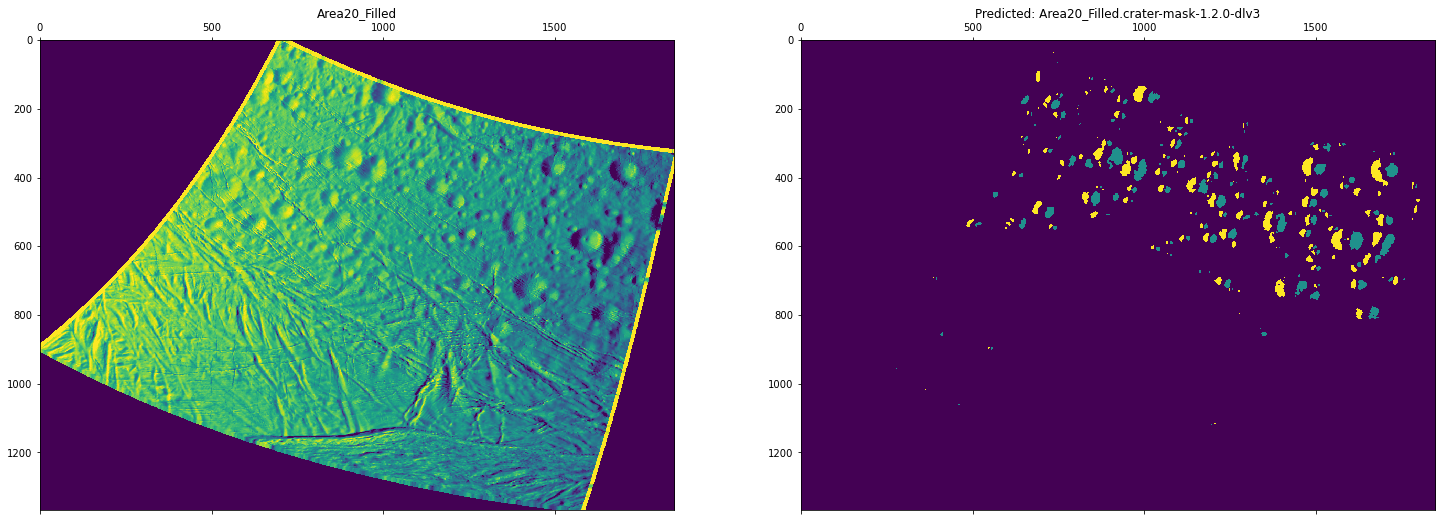

In [12]:
figure, axis = plt.subplots(1, 2, figsize=(25,15))
axis[0].matshow(inputnd)
axis[0].set_title(prediction_scene.split('/')[-1].replace('.tif', ''))

axis[1].matshow(outputnd)
axis[1].set_title("Predicted: {}".format(prediction.split('/')[-1].replace('.tif', '')))

plt.show()